## RSNA 2022 Cervical Spine Fracture Detection Deep learning project


dependcies
Note:all directories can be reached by adding the project dataset from kaggel or downloading it on your local machine

In [2]:
!pip install -q ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl
!pip install -q ../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q ../input/for-pydicom/pylibjpeg_libjpeg-1.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

## Imports

In [2]:
import os 
import pathlib
import glob 
from tqdm import tqdm 

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom

In [3]:
sns.set()

In [4]:
## Parameters
EPOCHS = 10
BATCH_SIZE = 16
IMAGE_SIZE = (512, 512)
SEED = 42

In [5]:
# set seed
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data  EDA and Processing

In [6]:
 # the input root folder 
DATA_DIR = "../input/rsna-2022-cervical-spine-fracture-detection/"

In [7]:
# lets list the contents inside the root folder
os.listdir(DATA_DIR)

['sample_submission.csv',
 'train_images',
 'train_bounding_boxes.csv',
 'segmentations',
 'train.csv',
 'test.csv',
 'test_images']

In [8]:
# look at what is in the train.csv
train_df = pd.read_csv(DATA_DIR + "train.csv")
train_df.head(10)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
5,1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0
6,1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
7,1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0
8,1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0
9,1.2.826.0.1.3680043.24045,1,0,0,0,0,0,0,1


In [10]:
train_df.size

18171

In [11]:
# how many unique study instances do we have
train_df.StudyInstanceUID.nunique()

2019

The train dataframe has metadata for the each study instance, c1..c7 are the cervical vertebrae planes and the values in the rows states whether it is fractured or not.

We will use this for our  model.

In [12]:
# a little deeper inside the train images
os.listdir(DATA_DIR + "train_images")[:5]

['1.2.826.0.1.3680043.17625',
 '1.2.826.0.1.3680043.3850',
 '1.2.826.0.1.3680043.2286',
 '1.2.826.0.1.3680043.14435',
 '1.2.826.0.1.3680043.3442']

we can see that the train images folder has other subfolders with the study id has its name. Each study can contain several instances with several frames and for this case slices in dicom format.

In [13]:
study_instance = "1.2.826.0.1.3680043.17625"
# list the first 5 frames in a select study instance
os.listdir(DATA_DIR + f"train_images/{study_instance}")[:5]

['12.dcm', '210.dcm', '120.dcm', '208.dcm', '141.dcm']

In [14]:
# select all the dicom files in the study instance
img_list = glob.glob(DATA_DIR + f"/train_images/{study_instance}/*.dcm")
len(img_list)

239

### Data Loading Functionalities 

In [15]:
def load_dicom(path):
    """
    reads a dicom file and loads the image array inside it
    inputs:
        path: the path of the required dicom file
    returns:
        data: image pixel arrays
    """
    img=pydicom.dcmread(path)
    data=img.pixel_array
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)
    return data

In [16]:
def data_generator():
    """
    a function that will load the dataset from a list of image paths
    """
    for path in img_list:
        data = load_dicom(path)
        yield data  # return the data has generator

In [17]:
# lets define a tensorflow dataset variable that will use the generator to get the image data
# this is efficient beacuse it will only load the data into memory when needed
train_dataset = tf.data.Dataset.from_generator(data_generator, (tf.uint8))

2023-01-07 16:54:49.129753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-01-07 16:54:49.130787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-01-07 16:54:49.279713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-01-07 16:54:49.280668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-01-07 16:54:49.281450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read fr

In [18]:
# a quick look of the dataset contents
for i in train_dataset.take(1):
    print(i.shape)
    print(type(i))

(512, 512)

<class 'tensorflow.python.framework.ops.EagerTensor'>


2023-01-07 16:54:52.802691: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Data Visualization

In [19]:
def show_single(img, cmap="gray"):
    """
    plots a single image
    """
    plt.imshow(img, cmap=cmap)
    plt.axis("off")

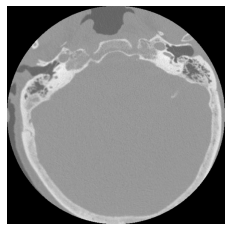

In [20]:
show_single(i)

In [21]:
def show_batch(cmap="gray"):
    """
    visualizes a batch of images
    """
    plt.figure(figsize=(16, 12))
    for i, img in enumerate(train_dataset.take(20)):  # iterate through the dataset
        plt.subplot(4, 5, i+1)
        show_single(img, cmap=cmap)
    plt.show()

#### A look of the images using different color maps

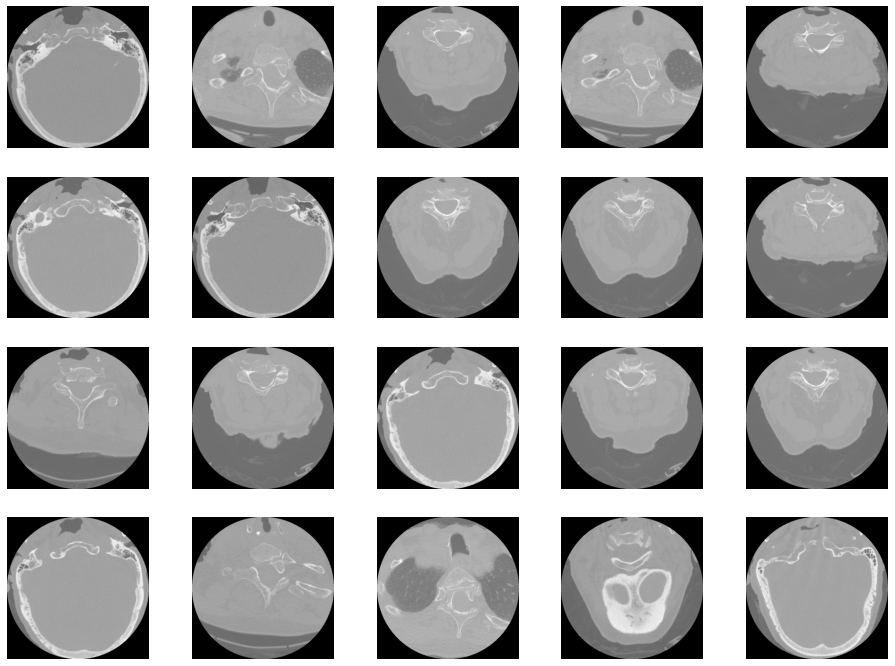

In [22]:
show_batch(cmap="gray")

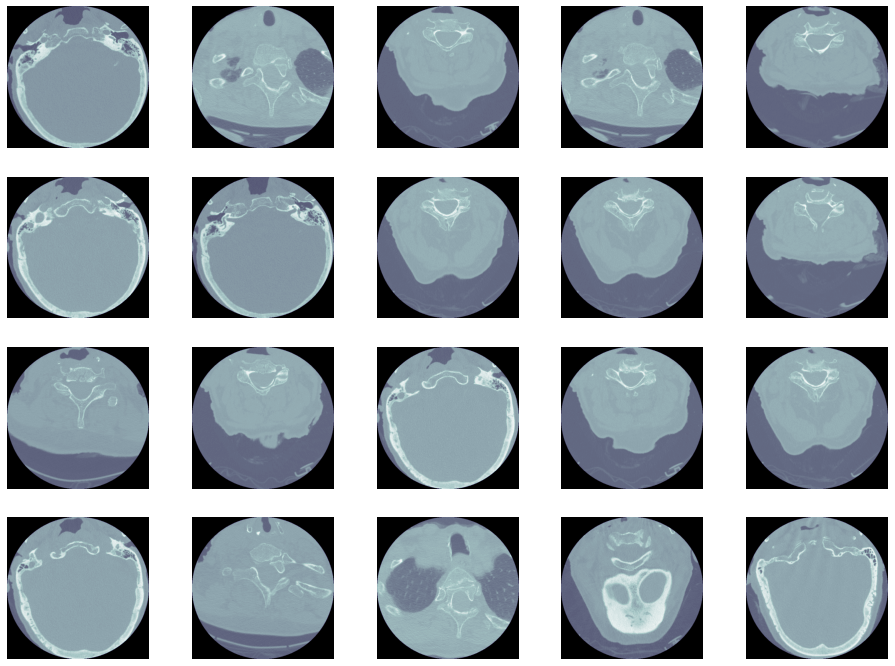

In [23]:
show_batch(cmap="bone")

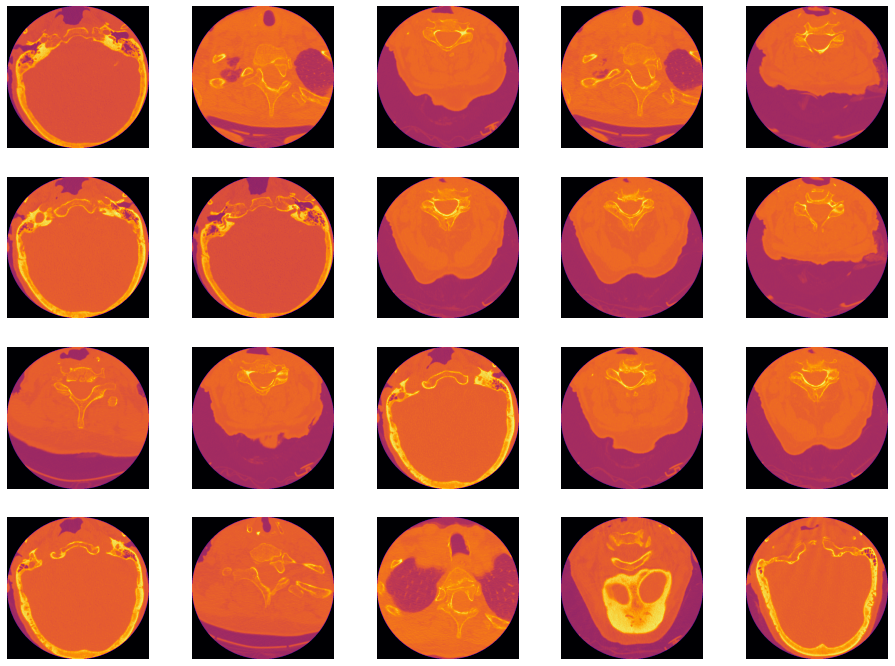

In [24]:
show_batch(cmap="inferno")

We have so far loaded the images, but it is not ready for training. We need to map the labels from the train_df and as seen earlier, we have 2019 unique study instances. Hence, we have to create a nested loop to iterate through all the study instances and the dicom files inside each study instance.

(0.0, 2800.0)

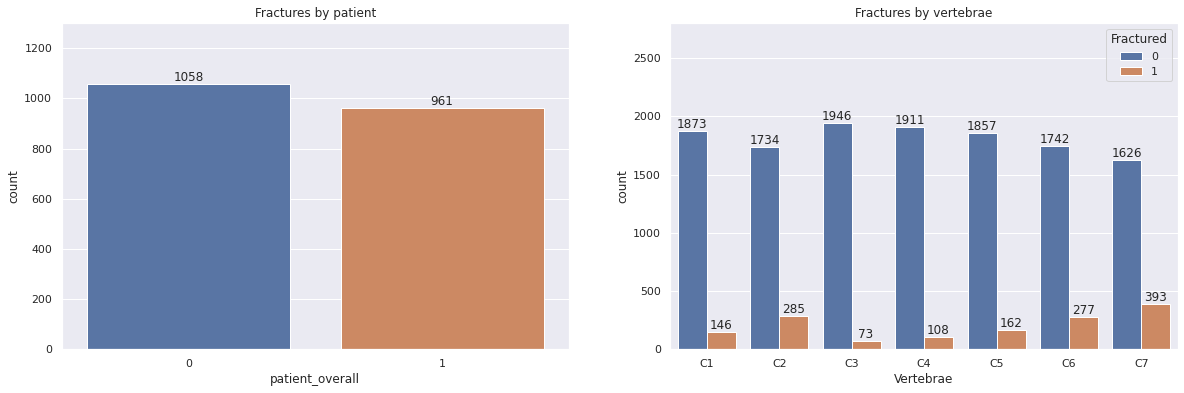

In [9]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_df, x='patient_overall')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fractures by patient')
plt.ylim([0,1300])

# Unpivot train_df for plotting
train_melt = pd.melt(train_df, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vertebrae",
             value_name="Fractured")

plt.subplot(1,2,2)
ax2 = sns.countplot(data=train_melt, x='Vertebrae', hue='Fractured')
for container in ax2.containers:
    ax2.bar_label(container)
plt.title('Fractures by vertebrae')
plt.ylim([0,2800])

(0.0, 1300.0)

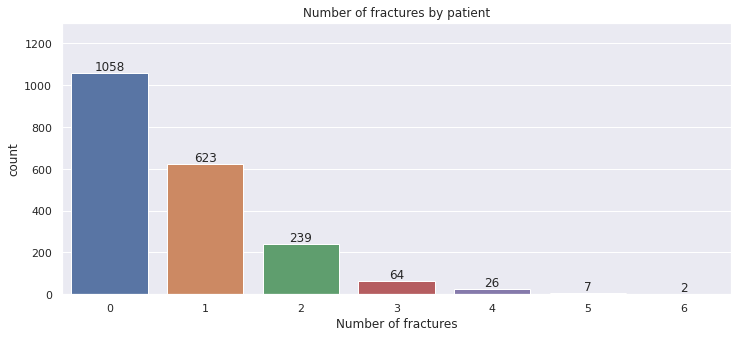

In [10]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x = train_df[['C1','C2','C3','C4','C5','C6','C7']].sum(axis=1))
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of fractures by patient')
plt.xlabel('Number of fractures')
plt.ylim([0,1300])

Text(0.5, 1.0, 'Correlations')

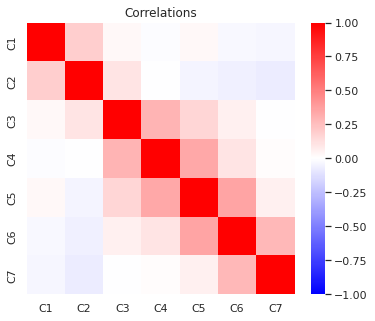

In [11]:


# Heatmap of correlations
plt.figure(figsize=(6,5))
sns.heatmap(train_df[['C1','C2','C3','C4','C5','C6','C7']].corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title('Correlations')



In [25]:
# lets modify the data generator, use 10 study instances
def data_generator():
    for i, study_instance in enumerate(train_df.StudyInstanceUID[:5]):
        for dcm in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
            train_labels = []
            path = DATA_DIR + f"train_images/{study_instance}/{dcm}"
            
            img = load_dicom(path)
            
            # resize each image into a shape of (512, 512)
            img = np.resize(img, (512, 512))
            #  normalize image
            img = img / 255.0
            # convert from gray scale to rgb, this will be helpful incase we want to use pretrained models
            img = tf.expand_dims(img, axis=-1)
            img = tf.image.grayscale_to_rgb(img)
            
            train_labels.extend([
                train_df.loc[i, "C1"],
                train_df.loc[i, "C2"],
                train_df.loc[i, "C3"],
                train_df.loc[i, "C4"],
                train_df.loc[i, "C5"],
                train_df.loc[i, "C6"],
                train_df.loc[i, "C7"],
                train_df.loc[i, "patient_overall"] # end with patient overall
            ])
            yield img, train_labels

In [26]:
train_data = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.int8))

In [27]:
for img, label in train_data.take(1):
    print(img.shape)
    print(label.shape)
    print(label)


(512, 512, 3)

(8,)

tf.Tensor([1 1 0 0 0 0 0 1], shape=(8,), dtype=int8)


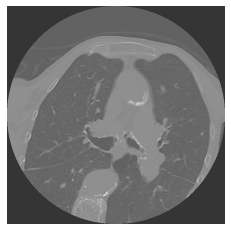

In [28]:
# visualize the image once again
show_single(img, cmap="gray")

Now we have our one-hot encoded labels, the last thing is to prepare the dataset for training by batching, catching and shuffling

### Split into train and validation

In [29]:
# we first need to know the number of data points we are dealing with
img_count = 0
for _, _ in enumerate(train_df.StudyInstanceUID[:5]):
    for _ in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
        img_count += 1
print(img_count)

1195


In [30]:
val_size = int(img_count * 0.2)
print(val_size)
train_data = train_data.skip(val_size)
val_data = train_data.take(val_size)

239


In [31]:
def configure_for_performance(data):
    data = data.cache()
    data = data.batch(16)
    data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return data

In [32]:
train_data = configure_for_performance(train_data)
val_data = configure_for_performance(val_data)


# Modelling

In [33]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten

In [34]:
# Define Alex Net model
def alex_net():
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(512,512,3), kernel_size=(11,11),\
     strides=(4,4), padding='valid', activation="relu"))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid', activation="relu"))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu"))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu"))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu"))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Passing it to a dense layer
    model.add(Flatten())
    # 1st Dense Layer
    model.add(Dense(4096, input_shape=(512*512*3,), activation="relu"))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 2nd Dense Layer
    model.add(Dense(4096, activation="relu"))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Dense Layer
    model.add(Dense(1000, activation="relu"))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer with 8 probability classes
    model.add(Dense(8, activation="softmax"))
    return model



In [35]:
model = alex_net()

In [36]:
model.summary()

Model: "sequential"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d (Conv2D)              (None, 126, 126, 96)      34944     

_________________________________________________________________

max_pooling2d (MaxPooling2D) (None, 63, 63, 96)        0         

_________________________________________________________________

batch_normalization (BatchNo (None, 63, 63, 96)        384       

_________________________________________________________________

conv2d_1 (Conv2D)            (None, 53, 53, 256)       2973952   

_________________________________________________________________

max_pooling2d_1 (MaxPooling2 (None, 26, 26, 256)       0         

_________________________________________________________________

batch_normalization_1 (Batch (None, 26, 26, 256)       1024      

_________________________________________________________________

conv2d_2 (Conv2D)            (None, 24, 

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(multi_label=True)])             


In [38]:
# training
history = model.fit(train_data, validation_data=val_data,epochs=EPOCHS)

Epoch 1/10


2023-01-07 16:55:12.810178: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


94/94 [==============================] - 78s 609ms/step - loss: 0.5011 - auc: 0.2571 - val_loss: 0.3484 - val_auc: 0.0566

Epoch 2/10

94/94 [==============================] - 12s 122ms/step - loss: 0.3456 - auc: 0.2362 - val_loss: 0.3059 - val_auc: 0.0245

Epoch 3/10

94/94 [==============================] - 11s 122ms/step - loss: 0.2921 - auc: 0.2304 - val_loss: 0.2188 - val_auc: 0.0674

Epoch 4/10

94/94 [==============================] - 12s 124ms/step - loss: 0.2756 - auc: 0.2419 - val_loss: 0.2550 - val_auc: 0.0598

Epoch 5/10

94/94 [==============================] - 12s 124ms/step - loss: 0.2690 - auc: 0.2381 - val_loss: 0.2548 - val_auc: 0.0706

Epoch 6/10

94/94 [==============================] - 12s 126ms/step - loss: 0.2640 - auc: 0.2660 - val_loss: 0.2613 - val_auc: 0.0460

Epoch 7/10

94/94 [==============================] - 12s 125ms/step - loss: 0.2616 - auc: 0.2357 - val_loss: 0.2739 - val_auc: 0.0747

Epoch 8/10

94/94 [==============================] - 12s 127ms/step

In [39]:
# visualize training 
def viz_loss(history):
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    iters = [i for i in range(EPOCHS)]
    
    plt.plot(iters, train_loss, label="Training Loss")
    plt.plot(iters, val_loss, label="Validation Loss")
    plt.title("A plot of Loss against number of iterations")
    plt.legend()
    plt.show()
    
def viz_acc(history):
    train_loss = history["auc"]
    val_loss = history["val_auc"]
    iters = [i for i in range(EPOCHS)]
    
    plt.plot(iters, train_loss, label="Training Accuracy")
    plt.plot(iters, val_loss, label="Validation Accuracy")
    plt.title("A plot of Accuracy against number of iterations")
    plt.legend()
    plt.show()

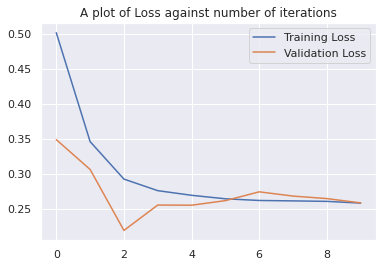

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


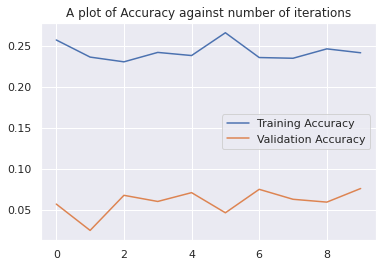

In [40]:
viz_loss(history.history)
print(history.history.keys())
viz_acc(history.history)

# Testing 

In [65]:
global test_ids
test_ids = []
def test_data_generator():
    for i, study_instance in enumerate(train_df.StudyInstanceUID[5:7]):
        for dcm in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
            test_labels = []

            path = DATA_DIR + f"train_images/{study_instance}/{dcm}"
            img = load_dicom(path)
            
            # resize each image into a shape of (512, 512)
            img = np.resize(img, (512, 512))
            #  normalize image
            img = tf.cast(img, tf.float32) / 255.0
            # convert from gray scale to rgb, this will be helpful incase we want to use pretrained models
            img = tf.expand_dims(img, axis=-1)
            img = tf.image.grayscale_to_rgb(img)
            test_ids.append(study_instance)
            test_labels.extend([
                train_df.loc[i, "C1"],
                train_df.loc[i, "C2"],
                train_df.loc[i, "C3"],
                train_df.loc[i, "C4"],
                train_df.loc[i, "C5"],
                train_df.loc[i, "C6"],
                train_df.loc[i, "C7"],
                train_df.loc[i, "patient_overall"] # end with patient overall
            ])
            yield img , test_labels

In [66]:
# make predictions
test_data = tf.data.Dataset.from_generator(test_data_generator, (tf.float32, tf.int8)).batch(1)
preds = []
images=list()
labels=list()
for img,label in tqdm(test_data):
    images.append(img)
    labels.append(label)
    preds.append(model.predict(img)[0])
preds = np.array(preds)

638it [00:43, 14.76it/s]


In [67]:
preds


array([[1.25519355e-08, 1.64199024e-01, 1.26679162e-11, ...,
        2.75390954e-09, 1.40815382e-09, 8.23790371e-01],
       [9.17996523e-09, 1.56982139e-01, 8.57233728e-12, ...,
        2.13604179e-09, 9.76747017e-10, 8.31758320e-01],
       [9.63789034e-07, 1.80404574e-01, 5.27216004e-09, ...,
        3.47523041e-07, 1.46587723e-07, 7.97287524e-01],
       ...,
       [6.15854631e-04, 2.30795801e-01, 4.83596159e-05, ...,
        3.51530412e-04, 1.87089230e-04, 7.00020790e-01],
       [1.24582542e-07, 1.55727893e-01, 4.55398302e-10, ...,
        4.26679740e-08, 1.68126295e-08, 8.28296483e-01],
       [1.26223254e-03, 2.35708296e-01, 9.97251409e-05, ...,
        6.71098416e-04, 4.42079909e-04, 6.84249580e-01]], dtype=float32)

In [68]:
assert len(test_ids) == len(preds)
print(len(preds))

638


In [69]:
result = pd.DataFrame(columns = ["StudyInstanceUID", 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'patient_overall'])

In [70]:
for i in tqdm(range(len(test_ids))):
    result.loc[i, 'StudyInstanceUID'] = test_ids[i]
    rows = preds[i].round(3)
    result.loc[i, 'C1'] = rows[0]
    result.loc[i, 'C2'] = rows[1]
    result.loc[i, 'C3'] = rows[2]
    result.loc[i, 'C4'] = rows[3]
    result.loc[i, 'C5'] = rows[4]
    result.loc[i, 'C6'] = rows[5]
    result.loc[i, 'C7'] = rows[6]
    result.loc[i, 'patient_overall'] = rows[7]

100%|██████████| 638/638 [00:00<00:00, 926.02it/s] 


In [71]:
print(len(result))
print("")
result.head(5)


638




,StudyInstanceUID,C1,C2,C3,C4,C5,C6,C7,patient_overall
0,1.2.826.0.1.3680043.4859,0.0,0.164,0.0,0.0,0.012,0.0,0.0,0.824
1,1.2.826.0.1.3680043.4859,0.0,0.157,0.0,0.0,0.011,0.0,0.0,0.832
2,1.2.826.0.1.3680043.4859,0.0,0.18,0.0,0.0,0.022,0.0,0.0,0.797
3,1.2.826.0.1.3680043.4859,0.0,0.17,0.0,0.0,0.015,0.0,0.0,0.815
4,1.2.826.0.1.3680043.4859,0.0,0.159,0.0,0.0,0.011,0.0,0.0,0.83


In [72]:

images= tf.convert_to_tensor(images)
labels= tf.convert_to_tensor(labels)
print(labels.shape)

evaluation=model.evaluate(test_data)



(638, 1, 8)

638/638 [==============================] - 16s 25ms/step - loss: 1.1714 - auc: 0.0579


In [1]:
print("loss"+"                       auc")
print(evaluation)



loss                       auc

[0.91714023351669312, 0.612926829904317856]


In [75]:
FRAC_COLS = [f'C{i}' for i in range(1, 8)]
VERT_COLS = [f'C{i}' for i in range(1, 8)]
def patient_prediction(df):
    c1c7 = np.average(df[FRAC_COLS].values, axis=0, weights=df[VERT_COLS].values)
    pred_patient_overall = 1 - np.prod(1 - c1c7)
    return pd.Series(data=np.concatenate([[pred_patient_overall], c1c7]), index=['patient_overall'] + [f'C{i}' for i in range(1, 8)])

df_patient_pred = result.groupby('StudyInstanceUID').apply(lambda df: patient_prediction(result))
df_patient_pred

,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,
1.2.826.0.1.3680043.18659,0.264646,0.004601,0.202382,0.001465,0.001517,0.067124,0.001658,0.002537
1.2.826.0.1.3680043.4859,0.264646,0.004601,0.202382,0.001465,0.001517,0.067124,0.001658,0.002537
